[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//incubodac/GradCamTP/blob/main/GradCam.ipynb)


# Introducción

La explicabilidad en redes neuronales convolucionales (CNN) ha surgido como un aspecto clave en el campo del reconocimiento de patrones, donde no solo interesa alcanzar un alto desempeño, sino también comprender qué información utiliza la red para tomar decisiones. Un primer avance fue **Class Activation Mapping (CAM, 2016)**, que permitió visualizar las regiones más relevantes de una imagen para la clasificación, aunque con la limitación de aplicarse únicamente a arquitecturas específicas con *global average pooling*. Más adelante, **Grad-CAM (2017)** amplió esta idea utilizando gradientes retropropagados, logrando un método versátil aplicable a una amplia variedad de arquitecturas y consolidándose como la técnica de referencia en explicabilidad. A partir de allí se desarrollaron extensiones como **Grad-CAM++ (2018)**, que mejora la localización en escenarios complejos, y **Score-CAM (2019)**, que evita depender directamente de los gradientes. Sin embargo, el salto conceptual decisivo que abrió la puerta al estudio moderno de la explicabilidad fue el de Grad-CAM.

---

## CAM

CAM fue introducido por Zhou et al. (2016) y se basa en la utilización de una capa de *global average pooling (GAP)* antes de la capa final de clasificación. La idea es que los pesos de la capa de salida pueden emplearse para ponderar los mapas de activación de la última capa convolucional, generando así un mapa de calor que indica las regiones de la imagen más relevantes para una clase determinada.

Se contruyen los mapas de activacion para cada clase de interes como:

$$
M_c(x,y) = \sum_k w_k^c f_k(x,y)
$$

donde:

* $M_c(x,y)$ es el mapa de activación para la clase $c$,
* $f_k(x,y)$ es el mapa de activación de la característica $k$,
* $w_k^c$ es el peso asociado a la clase $c$ en la capa de salida.


Además de requerir global average pooling, CAM solo puede aplicarse a capas cuya ultima capa sea una red densa.
Un uso interesante es la posibilidad de hacer localizacion de objetos mediante una red que no haya sido entrenada con bounding boxes http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf
**Referencia:**
Zhou, B., Khosla, A., Lapedriza, A., Oliva, A., & Torralba, A. (2016). *Learning Deep Features for Discriminative Localization*. CVPR.

---

## Grad-CAM

**Aporte:**
Grad-CAM, propuesto por Selvaraju et al. (2017), generaliza la idea de CAM para que pueda aplicarse a una gran variedad de arquitecturas. Utiliza los gradientes de la clase de interés respecto a los mapas de activación de una capa convolucional, ponderando las características de acuerdo con su importancia para la predicción.

**Fórmula principal:**

1. Calcular los gradientes de la puntuación de la clase $y^c$ respecto a los mapas de activación $A^k$:

$$
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}
$$

2. Generar el mapa de activación como:

$$
L_{\text{Grad-CAM}}^c = ReLU\left(\sum_k \alpha_k^c A^k \right)
$$

donde $ReLU$ asegura que solo se conserven las contribuciones positivas.

**Ventajas:**

* Se puede aplicar a múltiples arquitecturas (sin necesidad de GAP).
* Permite obtener explicaciones visuales interpretables en tareas de clasificación, detección y segmentación.

**Limitaciones:**

* La resolución espacial del mapa depende de la capa elegida (generalmente baja).
* Tiende a resaltar regiones amplias sin un detalle fino de contornos.

**Referencia:**
Selvaraju, R. R., et al. (2017). *Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization*. ICCV.

---

## Variantes

Con la intención de mejorar la definición y la estabilidad de los mapas de calor explicativos, se han propuesto diversas variantes de Grad-CAM. Estas buscan refinar la localización, reducir la dependencia de los gradientes o aumentar la resolución espacial de las visualizaciones.

### Grad-CAM++ (2018)

* **Idea:** ajusta la forma de calcular los pesos $\alpha_k^c$ para tener en cuenta múltiples instancias de un mismo objeto en la imagen.
* **Pro:** produce mapas más precisos en escenarios complejos y con objetos superpuestos.
* **Con:** mayor costo computacional y complejidad en el cálculo.

### Score-CAM (2019)

* **Idea:** reemplaza los gradientes por una estrategia basada en la contribución directa de cada mapa de activación, evaluando su impacto en la puntuación de la clase al reinyectarlo en la red.
* **Pro:** evita problemas de inestabilidad que pueden aparecer con gradientes.
* **Con:** requiere múltiples pasadas hacia adelante por la red, aumentando significativamente el tiempo de cómputo.

### Finer-CAM y otras variantes recientes

* **Idea:** mejorar la resolución espacial de los mapas y capturar bordes con mayor detalle mediante *upsampling*, mecanismos de atención o la combinación de capas de diferentes niveles.
* **Pro:** mapas más detallados y cercanos a las estructuras de los objetos.
* **Con:** mayor complejidad y dependencia de parámetros adicionales.


## Conclusión

La explicabilidad en redes convolucionales constituye un eje central en el reconocimiento de patrones, ya que permite comprender cómo y por qué una red llega a una determinada predicción. En este contexto, **Grad-CAM** marcó un punto de inflexión al ofrecer un método general, interpretable y adaptable a múltiples arquitecturas, lo que lo convirtió en la técnica de referencia. Si bien las variantes posteriores como **Grad-CAM++** y **Score-CAM** han aportado mejoras en resolución y estabilidad, el aporte conceptual decisivo sigue siendo el de Grad-CAM, que abrió el camino hacia una mayor transparencia en los modelos de aprendizaje profundo.


- Grafico comparando todo

ejemplos imagenes probar distas redes/clases ......


- VIT que pasa con modelos mas complejo donde la tarea no incluye un FC

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Function to load images directly from URLs
def load_image_from_url(url, transform=None):
    """Load image directly from URL"""
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        if transform:
            image = transform(image)
        return image
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

# Define image preprocessing for ResNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Test images from different categories - these are free stock images
test_images = {
    'cat': 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400',
    'dog': 'https://images.unsplash.com/photo-1552053831-71594a27632d?w=400', 
    'car': 'https://images.unsplash.com/photo-1494976388531-d1058494cdd8?w=400',
    'bird': 'https://images.unsplash.com/photo-1444464666168-49d633b86797?w=400',
    'chita': 'https://images.unsplash.com/photo-1551969014-7d2c4cddf0b6?w=400',
    'airplane': 'https://images.unsplash.com/photo-1436491865332-7a61a109cc05?w=400',
    'ship': 'https://images.unsplash.com/photo-1544551763-46a013bb70d5?w=400'
}

# Alternative: Use sample images from torchvision (if available)
def get_sample_images():
    """Get sample images for testing"""
    images = {}
    
    print("Loading test images...")
    for name, url in test_images.items():
        print(f"Loading {name}...")
        # Load original image for display
        try:
            response = requests.get(url)
            original_img = Image.open(BytesIO(response.content)).convert('RGB')
            # Load preprocessed image for model
            preprocessed_img = load_image_from_url(url, preprocess)
            
            if preprocessed_img is not None:
                images[name] = {
                    'original': original_img,
                    'tensor': preprocessed_img.unsqueeze(0),  # Add batch dimension
                    'url': url
                }
                print(f"✓ {name} loaded successfully")
            else:
                print(f"✗ Failed to load {name}")
        except Exception as e:
            print(f"✗ Error loading {name}: {e}")
    
    return images

# Load all test images
sample_images = get_sample_images()

print(f"Loaded {len(sample_images)} test images")


Loading test images...
Loading cat...
✓ cat loaded successfully
Loading dog...
✓ dog loaded successfully
Loading car...
✓ car loaded successfully
Loading bird...
✓ bird loaded successfully
Loading chita...
✓ chita loaded successfully
Loading airplane...
✓ airplane loaded successfully
Loading ship...
✓ ship loaded successfully
Loaded 7 test images


In [3]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad,FinerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image 
from torchvision.models import resnet50


import torchvision
from PIL import Image
import numpy as np

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
# open an image file
image = sample_images['cat']['original']
image = image.convert("RGB")
image = image.resize((224, 224))

# Convert PIL image to numpy array and normalize to [0, 1]
rgb_img = np.float32(image) / 255

input_tensor = torchvision.transforms.ToTensor()(image).unsqueeze(0)
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(246)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

/Users/dac/miniconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dac/miniconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Get ImageNet class labels
import requests
import torch.nn.functional as F

def get_imagenet_classes():
    try:
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        classes = response.text.strip().split('\n')
        return classes
    except:
        return [f"class_{i}" for i in range(1000)]

imagenet_classes = get_imagenet_classes()

# Define interesting classes to visualize
interesting_classes = [
    282,  # tiger cat
    285,  # Egyptian cat
    281,  # tabby cat
    404,  # airliner
    817,  # sports car
    130   # flamingo
]

# check if the classes names are correct
for idx in interesting_classes:
    print(f"{idx}: {imagenet_classes[idx]}")



282: tiger cat
285: Egyptian cat
281: tabby
404: airliner
817: sports car
130: flamingo


Creating improved 7x7 GradCAM visualization grid...
Classes used: ['tiger cat', 'Egyptian cat', 'tabby', 'airliner', 'sports car', 'flamingo']


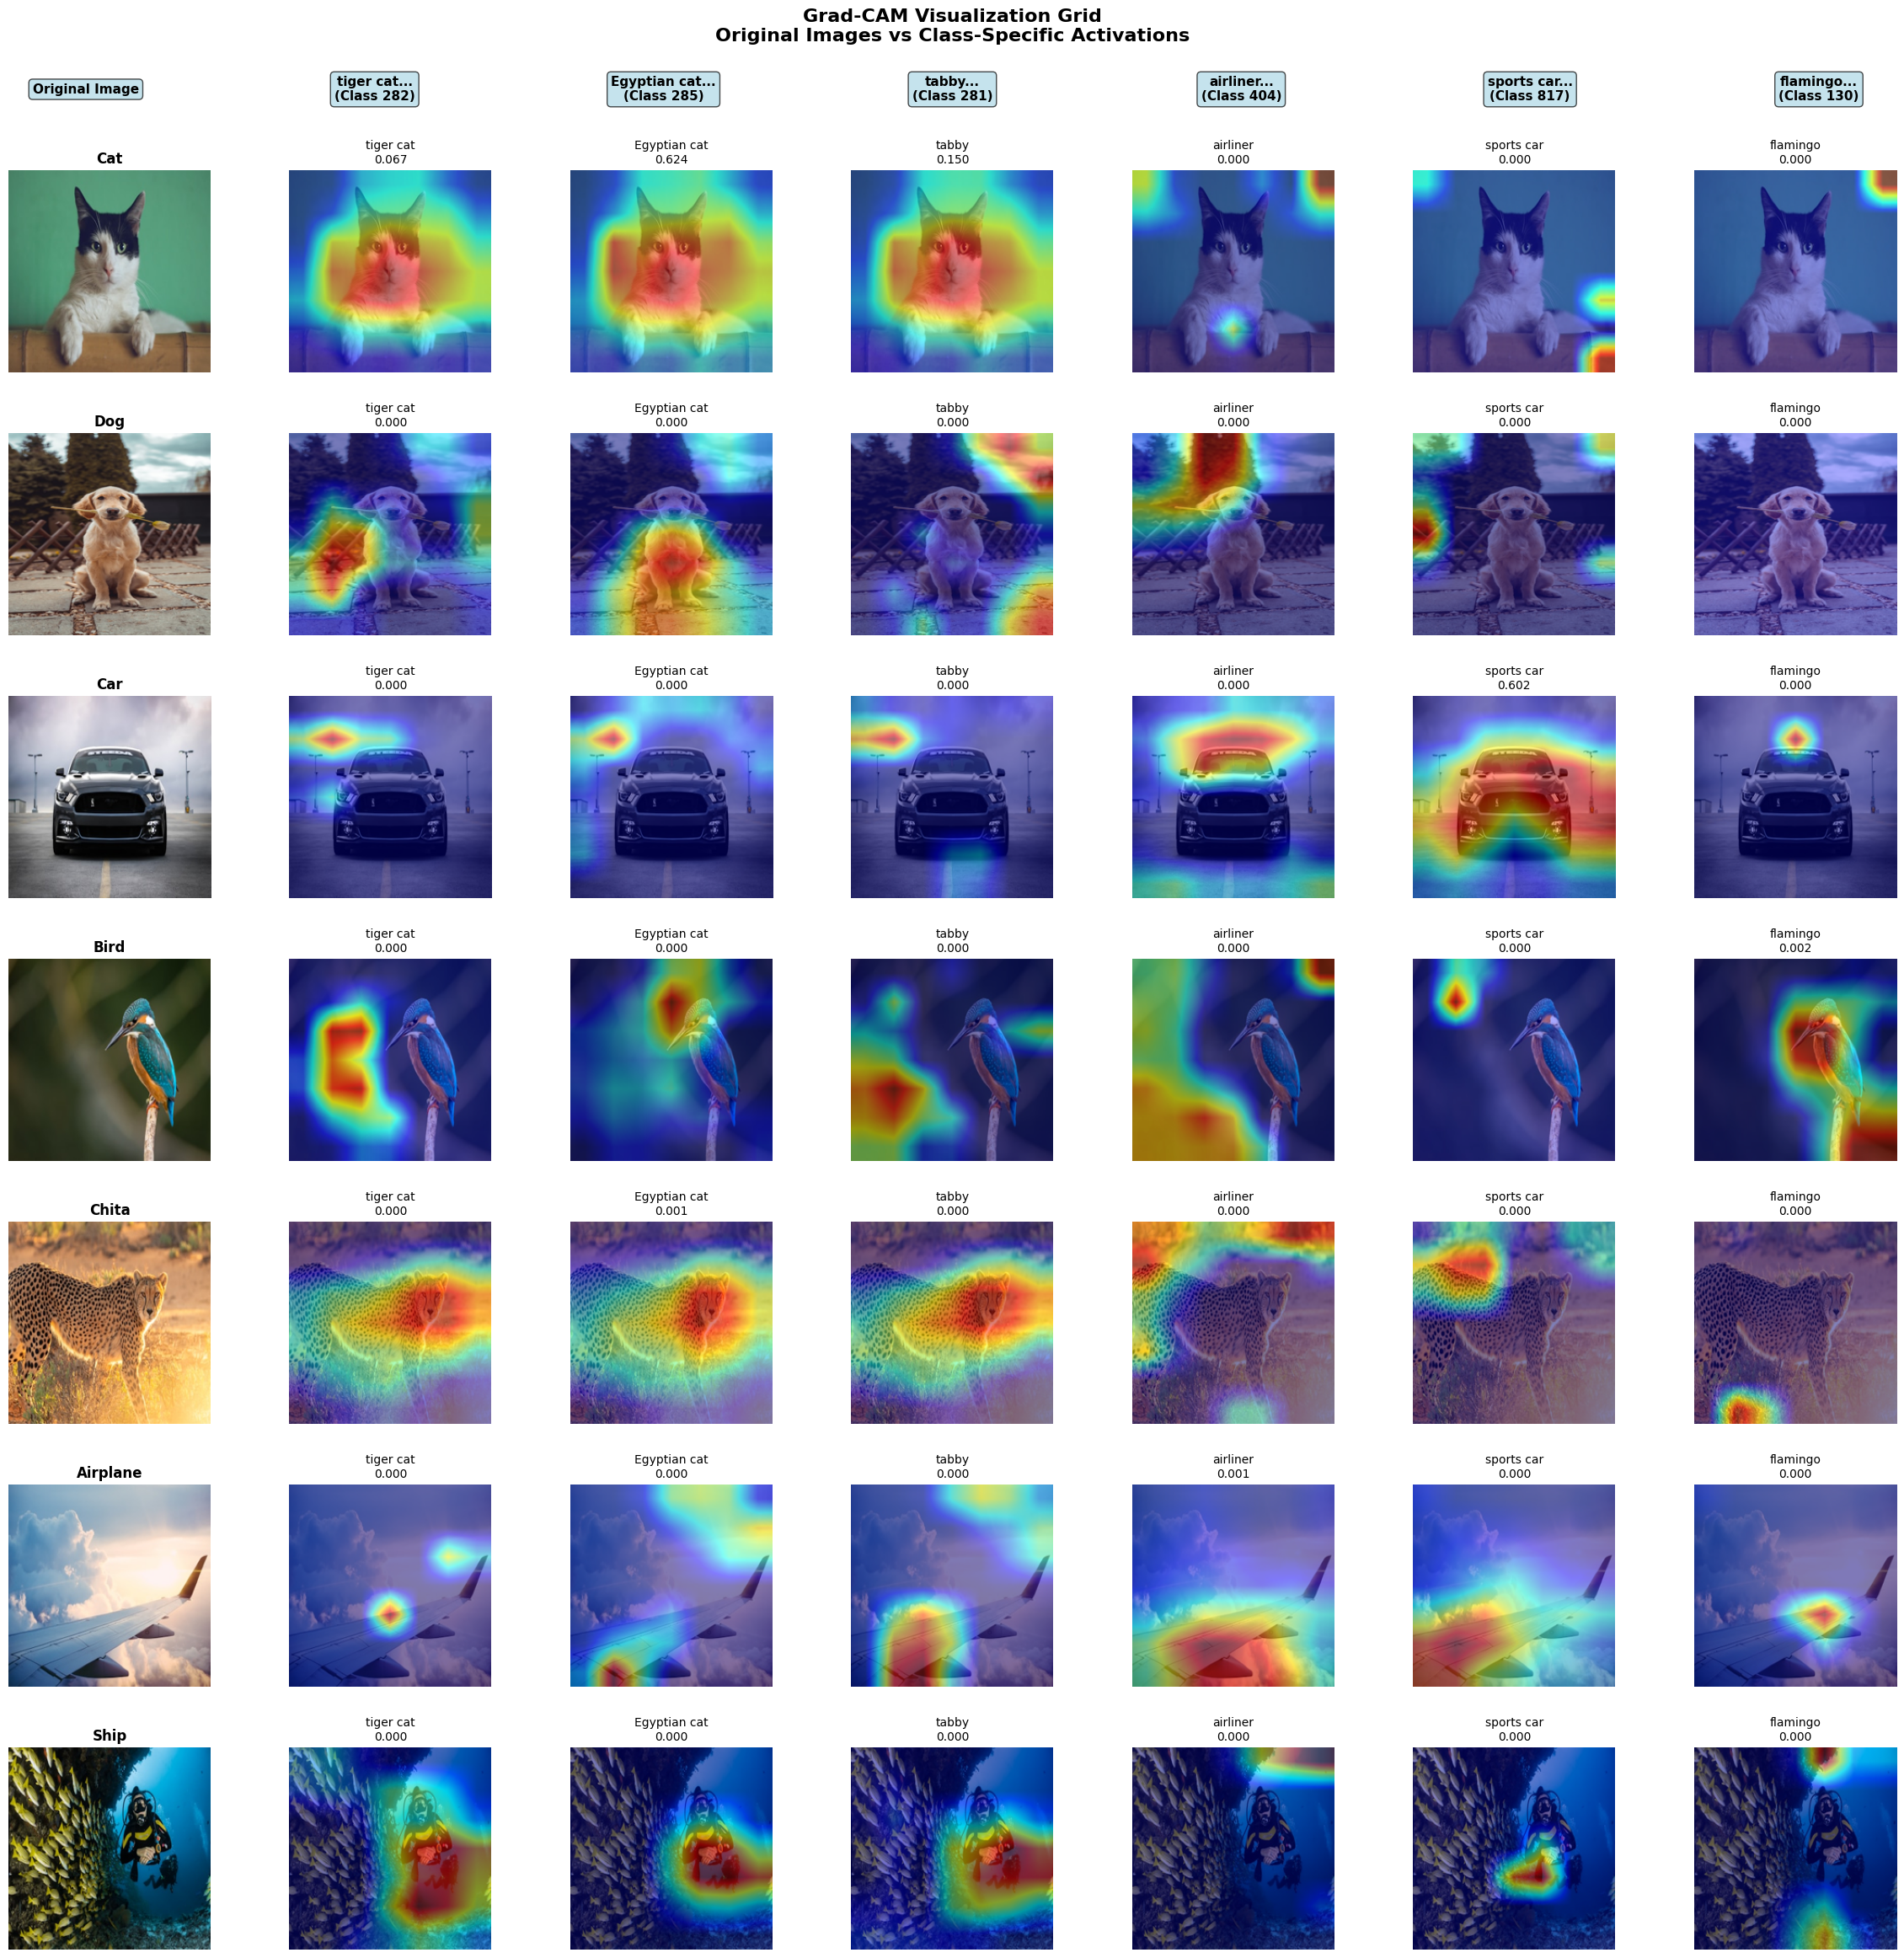

In [5]:
# Improved version with better layout
def create_improved_gradcam_grid(sample_images, interesting_classes):
    """Create a 7x7 grid with improved layout and spacing"""
    
    # Get first 7 images (or pad if less)
    image_names = list(sample_images.keys())[:7]
    
    # Create figure with better spacing
    fig, axes = plt.subplots(7, 7, figsize=(24, 24))
    
    # Set overall title
    fig.suptitle('Grad-CAM Visualization Grid\nOriginal Images vs Class-Specific Activations', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    for row, image_name in enumerate(image_names):
        if image_name not in sample_images:
            continue
            
        # Get image data
        image_data = sample_images[image_name]
        original_img = image_data['original']
        input_tensor = image_data['tensor']
        
        # Prepare original image for display
        display_img = original_img.resize((224, 224))
        rgb_img = np.float32(display_img) / 255
        
        # Column 0: Original image
        axes[row, 0].imshow(display_img)
        axes[row, 0].set_title(f'{image_name.capitalize()}', fontsize=12, fontweight='bold')
        axes[row, 0].axis('off')
        
        # Add a border around original images
        for spine in axes[row, 0].spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
            spine.set_color('black')
        
        # Columns 1-6: GradCAM for different classes
        for col, class_idx in enumerate(interesting_classes[:6], 1):
            try:
                # Create GradCAM for this specific class
                targets = [ClassifierOutputTarget(class_idx)]
                
                with GradCAM(model=model, target_layers=target_layers) as cam:
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                    grayscale_cam = grayscale_cam[0, :]
                    
                    # Create overlay visualization
                    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                    
                    # Get model output for this image
                    model_output = cam.outputs
                    probs = F.softmax(model_output, dim=1)
                    class_prob = probs[0, class_idx].item()
                
                axes[row, col].imshow(visualization)
                # Truncate long class names and add probability
                class_name = imagenet_classes[class_idx]
                if len(class_name) > 12:
                    class_name = class_name[:12] + "..."
                axes[row, col].set_title(f'{class_name}\n{class_prob:.3f}', fontsize=10)
                axes[row, col].axis('off')
                
            except Exception as e:
                # If there's an error, show a placeholder
                axes[row, col].text(0.5, 0.5, f'Error\n{str(e)[:15]}...', 
                                  ha='center', va='center', transform=axes[row, col].transAxes,
                                  fontsize=8)
                axes[row, col].set_title(f'Class {class_idx}', fontsize=10)
                axes[row, col].axis('off')
    
    # Hide empty rows if we have fewer than 7 images
    for row in range(len(image_names), 7):
        for col in range(7):
            axes[row, col].axis('off')
    
    # Add detailed column headers with class names
    col_headers = ['Original Image'] + [f'{imagenet_classes[cls][:15]}...\n(Class {cls})' 
                                       for cls in interesting_classes[:6]]
    
    # Position headers better
    for col, header in enumerate(col_headers):
        fig.text((col + 0.5)/7, 0.94, header, ha='center', va='center', 
                fontsize=11, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
    
    # Adjust layout with proper spacing
    plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space for title and headers
    plt.subplots_adjust(
        top=0.90,      # Space for title and headers
        bottom=0.02,   # Small bottom margin
        left=0.02,     # Small left margin
        right=0.98,    # Small right margin
        hspace=0.3,    # Vertical spacing between rows
        wspace=0.1     # Horizontal spacing between columns
    )
    
    plt.show()

# Create the improved grid visualization
print("Creating improved 7x7 GradCAM visualization grid...")
print(f"Classes used: {[imagenet_classes[i] for i in interesting_classes[:6]]}")

create_improved_gradcam_grid(sample_images, interesting_classes)

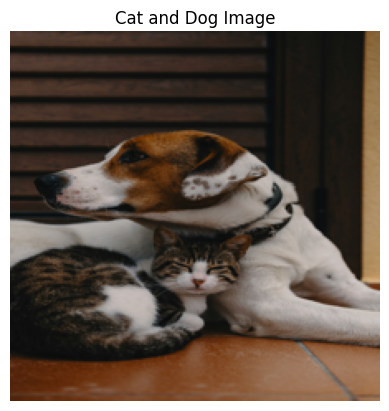

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

cat_dog_img = 'cat_dog.jpg'
cat_dog_img = Image.open(cat_dog_img).convert("RGB")
cat_dog_img = cat_dog_img.resize((224, 224))  

plt.imshow(cat_dog_img)
plt.axis('off')  # Optional: hide axes for cleaner display
plt.title('Cat and Dog Image')  # Optional: add title
plt.show()

In [7]:
import torch
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
import matplotlib.pyplot as plt
import numpy as np

# Enhanced CAM methods including more variants and Guided CAM
cam_methods = {
    'GradCAM': GradCAM(model=model, target_layers=target_layers),
    'GradCAM++': GradCAMPlusPlus(model=model, target_layers=target_layers),
    'HiResCAM': HiResCAM(model=model, target_layers=target_layers),
    'ScoreCAM': ScoreCAM(model=model, target_layers=target_layers),
    'XGradCAM': XGradCAM(model=model, target_layers=target_layers),
    'AblationCAM': AblationCAM(model=model, target_layers=target_layers),
    'EigenCAM': EigenCAM(model=model, target_layers=target_layers)
}

# Define cat and dog target classes (ImageNet class indices)
target_classes = {
    'Tiger Cat': 282,
    'Tabby Cat': 281,
    'Egyptian Cat': 285,
    'Golden Retriever': 207,
    'Beagle': 162,
    'German Shepherd': 235
}

# Function to create guided gradcam visualization
def create_guided_gradcam(model, input_tensor, target_class, target_layers):
    """Create Guided GradCAM visualization"""
    # Create guided backprop model
    guided_model = GuidedBackpropReLUModel(model=model, use_cuda=False)
    
    # Get guided gradients
    guided_grads = guided_model(input_tensor, target_category=target_class)
    guided_grads = guided_grads[0]
    guided_grads = np.transpose(guided_grads, (1, 2, 0))
    
    # Get GradCAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        targets = [ClassifierOutputTarget(target_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
    
    # Create guided gradcam by element-wise multiplication
    guided_gradcam = np.multiply(guided_grads, np.expand_dims(grayscale_cam, axis=2))
    
    # Normalize for visualization
    guided_gradcam = guided_gradcam - guided_gradcam.min()
    guided_gradcam = guided_gradcam / guided_gradcam.max()
    
    return guided_gradcam

# Generate visualizations for each method and each target class
method_class_visualizations = {}

for method_name, cam_instance in cam_methods.items():
    method_class_visualizations[method_name] = {}
    
    with cam_instance:
        for class_name, class_idx in target_classes.items():
            targets_class = [ClassifierOutputTarget(class_idx)]
            grayscale_cam = cam_instance(input_tensor=input_tensor, targets=targets_class)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            method_class_visualizations[method_name][class_name] = visualization

# Add Guided GradCAM visualizations
method_class_visualizations['Guided GradCAM'] = {}
for class_name, class_idx in target_classes.items():
    guided_gradcam_vis = create_guided_gradcam(model, input_tensor, class_idx, target_layers)
    method_class_visualizations['Guided GradCAM'][class_name] = guided_gradcam_vis

# Create comprehensive visualization grid
num_methods = len(method_class_visualizations)
num_classes = len(target_classes)

fig = plt.figure(figsize=(30, 20))

# Add main title
fig.suptitle('Comprehensive CAM Methods Comparison: Cat vs Dog Classification', 
             fontsize=20, fontweight='bold', y=0.98)

# Display grid: rows = methods, columns = original + classes
for row, (method_name, class_visualizations) in enumerate(method_class_visualizations.items()):
    # First column: Original image for each row
    plt.subplot(num_methods, num_classes + 1, row * (num_classes + 1) + 1)
    plt.imshow(rgb_img)
    plt.title(f'Original Image\n({method_name})', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Add border around original image
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)

    # Remaining columns: Class-specific visualizations
    for col, (class_name, visualization) in enumerate(class_visualizations.items(), 2):
        plt.subplot(num_methods, num_classes + 1, row * (num_classes + 1) + col)
        plt.imshow(visualization)
        
        # Color-code titles: cats in blue, dogs in orange
        if 'Cat' in class_name:
            title_color = 'blue'
        else:
            title_color = 'orange'
            
        plt.title(f'{class_name}\n(Class {target_classes[class_name]})', 
                 fontsize=10, fontweight='bold', color=title_color)
        plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
plt.show()

# Show model predictions for each target class
print("Model Predictions for Cat and Dog Classes:")
print("=" * 70)

# Get model predictions
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = F.softmax(outputs, dim=1)

# Separate cats and dogs
cat_classes = {k: v for k, v in target_classes.items() if 'Cat' in k}
dog_classes = {k: v for k, v in target_classes.items() if 'Cat' not in k}

print("🐱 CAT CLASSES:")
print("-" * 40)
for class_name, class_idx in cat_classes.items():
    prob = probabilities[0][class_idx].item()
    print(f"  {class_name:15} (Class {class_idx:3}): {prob:.6f} ({prob*100:.4f}%)")

print(f"\n🐶 DOG CLASSES:")
print("-" * 40)
for class_name, class_idx in dog_classes.items():
    prob = probabilities[0][class_idx].item()
    print(f"  {class_name:15} (Class {class_idx:3}): {prob:.6f} ({prob*100:.4f}%)")

print(f"\n📊 OVERALL PREDICTION:")
print("-" * 40)
predicted_class = probabilities[0].argmax().item()
max_prob = probabilities[0].max().item()
print(f"  Predicted class: {predicted_class}")
print(f"  Highest probability: {max_prob:.6f} ({max_prob*100:.4f}%)")

# Show method comparison summary
print(f"\n🔍 CAM METHODS ANALYZED:")
print("-" * 40)
for i, method_name in enumerate(method_class_visualizations.keys(), 1):
    print(f"  Row {i}: {method_name}")
    
print(f"\n🎯 TARGET CLASSES:")
print("-" * 40)
for i, (class_name, class_idx) in enumerate(target_classes.items(), 1):
    category = "🐱 Cat" if 'Cat' in class_name else "🐶 Dog"
    print(f"  Column {i+1}: {class_name} (Class {class_idx}) - {category}")

 26%|██▌       | 33/128 [01:27<04:10,  2.64s/it]


KeyboardInterrupt: 